Calculating the gain using the peaks extracted from just the Polya model fitted to the integral histograms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
#load the csvs with the peak information

#spe_df = pd.read_csv('spe_masked_polya_peak_positions.csv')
darkrate_df = pd.read_csv('darkrate_masked_polya_peak_positions_PMT2.csv')

#print('SPE')
#print(spe_df)
print('DARKRATE')
print(darkrate_df)

DARKRATE
    voltage  polya_peak_pC  polya_peak_error_pC
0      1750       1.334285             0.000115
1      1750       1.327989             0.000113
2      1750       1.331166             0.000114
3      1750       1.329097             0.000119
4      1750       1.328973             0.000113
5      1750       1.333139             0.000119
6      1800       1.485731             0.000193
7      1800       1.491155             0.000196
8      1800       1.487038             0.000200
9      1800       1.490932             0.000197
10     1800       1.483220             0.000195
11     1800       1.490214             0.000200
12     1850       1.833529             0.000460
13     1850       1.823098             0.000465
14     1850       1.833528             0.000453
15     1850       1.842227             0.000472
16     1850       1.824730             0.000455
17     1850       1.835544             0.000491
18     1900       2.365969             0.001051
19     1900       2.368374     

In [3]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

#spe_df = add_gain_columns(spe_df)
darkrate_df = add_gain_columns(darkrate_df)

In [4]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

#spe_avg_gain = average_gain_per_voltage(spe_df)
darkrate_avg_gain = average_gain_per_voltage(darkrate_df)

In [5]:
#gain model and fitting
def gain_model(V, A, B, c):
    return A * V**(14 * B) + c

def fit_gain_curve(voltage, gain, gain_err):
    p0 = [1e-20, 0.7, 1] #initial guesses

    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )

    A_fit, B_fit, c_fit = popt
    err_A, err_B, err_c = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, c_fit, err_A, err_B, err_c




#A_spe, B_spe, errA_spe, errB_spe = fit_gain_curve(
 #   spe_avg_gain['voltage'].values,
  #  spe_avg_gain['gain'].values,
   # spe_avg_gain['gain_error'].values
#)

A_dark, B_dark, c_dark, errA_dark, errB_dark, err_cdark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values
)

V_plot = np.linspace(
    darkrate_avg_gain['voltage'].min(), darkrate_avg_gain['voltage'].max(),300)


In [6]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced


#y_spe_model = gain_model(spe_avg_gain['voltage'].values, A_spe, B_spe)
#chi2_spe, chi2_red_spe = chi_squared(
    #spe_avg_gain['gain'].values,
    #y_spe_model,
    #spe_avg_gain['gain_error'].values,
    #n_params=2
#)


y_dark_model = gain_model(darkrate_avg_gain['voltage'].values, A_dark, B_dark, c_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:55: SyntaxWarning: invalid escape sequence '\p'
C:\Users\holly\AppData\Local\Temp\ipykernel_52088\84438900.py:20: SyntaxWarning: invalid escape sequence '\p'
  rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f}), \ C=({c_dark:.3f}\pm{err_cdark:.3f})$'
C:\Users\holly\AppData\Local\Temp\ipykernel_52088\84438900.py:55: SyntaxWarning: invalid escape sequence '\p'
  + f'\n$C=({c_dark:.3e}\pm{err_cdark:.3e})$'


<Figure size 600x600 with 0 Axes>

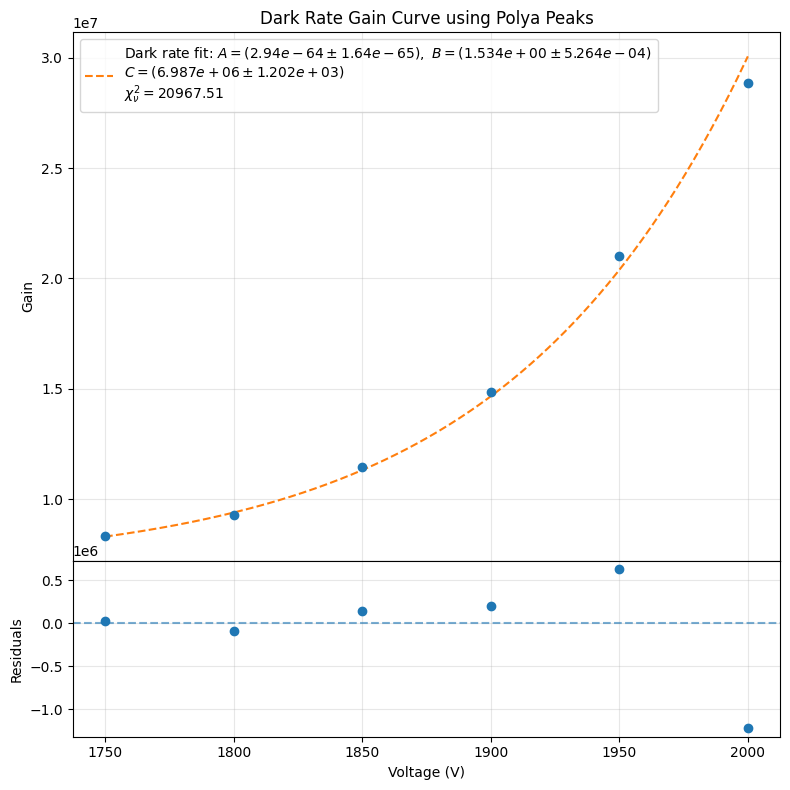

In [14]:
#plot gain curves and gain model = A V^14B separately
plt.figure(figsize=(6, 6))
#plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3)
#plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
#        rf'SPE fit: $A=({A_spe:.2e}\pm{errA_spe:.2e}),\ B=({B_spe:.3f}\pm{errB_spe:.3f})$'
#        + f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
#    ))
#plt.xlabel('Voltage (V)')
#plt.ylabel('Gain')
#plt.title('SPE Gain Curve using Polya Peaks')
#plt.grid(alpha=0.3)
#plt.tight_layout()
#plt.legend()
#plt.show()

"""
plt.figure(figsize=(6, 6))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange', capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark, c_dark),'--',color='tab:orange',label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f}), \ C=({c_dark:.3f}\pm{err_cdark:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('Dark Rate Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()
"""
fig, (ax_main, ax_res) = plt.subplots(
    nrows=2, 
    ncols=1, 
    sharex=True, 
    figsize=(8,8),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
)

# --- Main gain curve plot ---
ax_main.errorbar(
    darkrate_avg_gain['voltage'],
    darkrate_avg_gain['gain'],
    yerr=darkrate_avg_gain['gain_error'],
    fmt='o',
    capsize=3
)

ax_main.plot(
    V_plot,
    gain_model(V_plot, A_dark, B_dark, c_dark),
    '--',
    label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ '
        rf'B=({B_dark:.3e}\pm{errB_dark:.3e})$'
        + f'\n$C=({c_dark:.3e}\pm{err_cdark:.3e})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    )
)

ax_main.set_ylabel('Gain')
ax_main.set_title('Dark Rate Gain Curve using Polya Peaks')
ax_main.grid(alpha=0.3)
ax_main.legend()
ax_main.tick_params(axis='x', labelbottom=False)


# --- Residuals ---
V_data = darkrate_avg_gain['voltage'].values
gain_data = darkrate_avg_gain['gain'].values
gain_err = darkrate_avg_gain['gain_error'].values

gain_fit_data = gain_model(V_data, A_dark, B_dark, c_dark)
residuals = gain_data - gain_fit_data

ax_res.axhline(0, linestyle='--', alpha=0.6)
ax_res.errorbar(
    V_data,
    residuals,
    yerr=gain_err,
    fmt='o',
    capsize=3
)

ax_res.set_xlabel('Voltage (V)')
ax_res.set_ylabel('Residuals')
ax_res.grid(alpha=0.3)


plt.tight_layout()
plt.show()


TypeError: gain_model() missing 1 required positional argument: 'c'

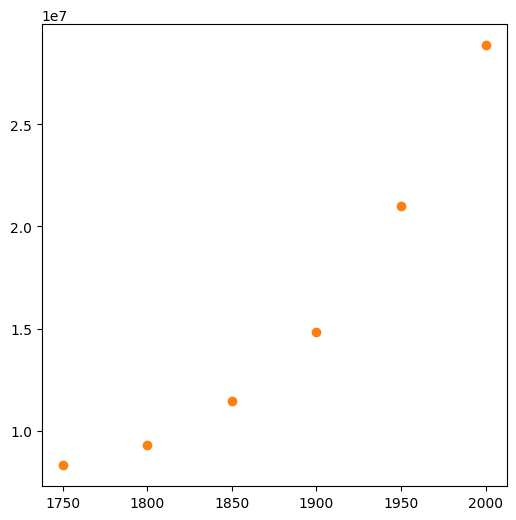

In [8]:
#plot gain curves and gain models = A V^14B together

plt.figure(figsize=(6, 6))
#plt.errorbar(spe_avg_gain['voltage'],spe_avg_gain['gain'],yerr=spe_avg_gain['gain_error'],fmt='o',color='tab:blue',capsize=3,label='SPE')
#plt.plot(V_plot,gain_model(V_plot, A_spe, B_spe),'--',color='tab:blue',label=(
 #   rf'SPE fit: '
  #  rf'$A = ({A_spe:.2e} \pm {errA_spe:.2e}),\ '
   # rf'B = ({B_spe:.3f} \pm {errB_spe:.3f})$'
    #+ f'\n$\\chi^2_\\nu={chi2_red_spe:.2f}$'
#))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange',capsize=3,label='Dark rate')
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
    rf'Dark rate fit: '
    rf'$A = ({A_dark:.2e} \pm {errA_dark:.2e}),\ '
    rf'B = ({B_dark:.3f} \pm {errB_dark:.4f})$'
    + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.legend()
plt.title(r'SPE and Darkrate Gain = $A V^{14B}$, using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
